In [ ]:
import torch
import numpy as np
import torch.nn as nn

import os
import imageio
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

In [ ]:
def get_rays(datapath, mode="train"):

    datapath = f"/content/drive/MyDrive/ColabNotebooks/NeRF/{datapath}"

    pose_file_names = [f for f in os.listdir(datapath + f'/{mode}/pose') if f.endswith('.txt')]
    intrisics_file_names = [f for f in os.listdir(datapath + f'/{mode}/intrinsics') if f.endswith('.txt')]
    img_file_names = [f for f in os.listdir(datapath + '/imgs') if mode in f]

    assert len(pose_file_names) == len(intrisics_file_names)
    assert len(img_file_names) == len(pose_file_names)

    # Read
    N = len(pose_file_names)
    poses = np.zeros((N, 4, 4))
    intrinsics = np.zeros((N, 4, 4))

    images = []

    for i in range(N):
        name = pose_file_names[i]

        pose = open(datapath + f'/{mode}/pose/' + name).read().split()
        poses[i] = np.array(pose, dtype=float).reshape(4, 4)

        intrinsic = open(datapath + f'/{mode}/intrinsics/' + name).read().split()
        intrinsics[i] = np.array(intrinsic, dtype=float).reshape(4, 4)

        # Read images
        img = imageio.imread(datapath + '/imgs/' + name.replace('txt', 'png')) / 255.
        images.append(img[None, ...])
    images = np.concatenate(images)

    H = images.shape[1]
    W = images.shape[2]

    if images.shape[3] == 4: #RGBA -> RGB
        images = images[..., :3] * images[..., -1:] + (1 - images[..., -1:])

    rays_o = np.zeros((N, H*W, 3))
    rays_d = np.zeros((N, H*W, 3))
    target_px_values = images.reshape((N, H*W, 3))

    for i in range(N):

        c2w = poses[i]
        f = intrinsics[i, 0, 0]

        u = np.arange(W)
        v = np.arange(H)
        u, v = np.meshgrid(u, v)
        dirs = np.stack((u - W / 2, -(v - H / 2), - np.ones_like(u) * f), axis=-1)
        dirs = (c2w[:3, :3] @ dirs[..., None]).squeeze(-1)
        dirs = dirs / np.linalg.norm(dirs, axis=-1, keepdims=True)

        rays_d[i] = dirs.reshape(-1, 3)
        rays_o[i] += c2w[:3, 3]

    return rays_o, rays_d, target_px_values

In [ ]:
def compute_accumulated_transmittance(betas):
    accumulated_transmittance = torch.cumprod(betas, 1)
    return torch.cat((torch.ones(accumulated_transmittance.shape[0], 1, device=accumulated_transmittance.device),
                      accumulated_transmittance[:, :-1]), dim=1)

def rendering(model, rays_o, rays_d, tn, tf, nb_bins=100, device='cpu', white_bckgr=True):

    t = torch.linspace(tn, tf, nb_bins).to(device) # [nb_bins]
    delta = torch.cat((t[1:] - t[:-1], torch.tensor([1e10], device=device)))

    x = rays_o.unsqueeze(1) + t.unsqueeze(0).unsqueeze(-1) * rays_d.unsqueeze(1) # [nb_rays, nb_bins, 3]

    colors, density = model.intersect(x.reshape(-1, 3))

    colors = colors.reshape((x.shape[0], nb_bins, 3)) # [nb_rays, nb_bins, 3]
    density = density.reshape((x.shape[0], nb_bins))

    alpha = 1 - torch.exp(- density * delta.unsqueeze(0)) # [nb_rays, nb_bins, 1]

    weights = compute_accumulated_transmittance(1 - alpha) * alpha # [nb_rays, nb_bins]

    if white_bckgr:
        c = (weights.unsqueeze(-1) * colors).sum(1) # [nb_rays, 3]
        weight_sum = weights.sum(-1) # [nb_rays]
        return c + 1 - weight_sum.unsqueeze(-1)
    else:
        c = (weights.unsqueeze(-1) * colors).sum(1) # [nb_rays, 3]

    return c

In [ ]:
class Voxels(nn.Module):

  def __init__(self, nb_voxels=100, scale=1.0, device="cuda"):
    super(Voxels, self).__init__()

    self.voxels = torch.nn.Parameter(torch.rand((nb_voxels, nb_voxels, nb_voxels, 4), device=device, requires_grad=True))

    self.nb_voxels = nb_voxels
    self.device = device
    self.scale = scale

  def forward(self, xyz):

    x = xyz[:, 0]
    y = xyz[:, 1]
    z = xyz[:, 2]

    cond = (x.abs() < (self.scale / 2)) & (y.abs() < (self.scale / 2)) & (z.abs() < (self.scale / 2))

    indx = (x[cond] / ((self.scale / self.nb_voxels)) + self.nb_voxels / 2).type(torch.long)
    indy = (y[cond] / ((self.scale / self.nb_voxels)) + self.nb_voxels / 2).type(torch.long)
    indz = (z[cond] / ((self.scale / self.nb_voxels)) + self.nb_voxels / 2).type(torch.long)

    colors_and_dansities = torch.zeros((xyz.shape[0], 4), device=xyz.device)
    colors_and_dansities[cond, :3] = self.voxels[indx, indy, indz, :3]
    colors_and_dansities[cond, -1] =self.voxels[indx, indy, indz, -1]

    return torch.sigmoid(colors_and_dansities[:, :3]), torch.relu(colors_and_dansities[:, -1:])

  def intersect(self, x):
    return self.forward(x)

# Camera / Dataset

In [ ]:
batch_size = 1024

o, d, target_px_values = get_rays("fox", mode="train")
dataloader = DataLoader(torch.cat((torch.from_numpy(o).reshape(-1, 3),
                                   torch.from_numpy(d).reshape(-1, 3),
                                   torch.from_numpy(target_px_values).reshape(-1, 3)), dim=1),
                        batch_size=batch_size, shuffle=True)

test_o, test_d, test_target_px_values = get_rays("fox", mode="test")

<ipython-input-8-5bf22eb51a89>:29: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(datapath + '/imgs/' + name.replace('txt', 'png')) / 255.


# Model

In [ ]:
# model = Voxels(scale=3.)

# Training

In [ ]:
from tqdm import tqdm

def training(model, optimizer, scheduler, tn, tf, nb_bins, nb_epochs, data_loader, device="cpu"):

  training_loss = []
  for epoch in tqdm(range(nb_epochs)):
    for batch in tqdm(data_loader):
      o = batch[:, :3].to(device)
      d = batch[:, 3:6].to(device)
      target= batch[:, 6:].to(device)

      prediction = rendering(model, o, d, tn, tf, nb_bins=nb_bins, device=device)

      loss = ((prediction - target)**2).mean()

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      training_loss.append(loss.item())

    scheduler.step()
  return training_loss

In [ ]:
device = "cuda"

tn = 8
tf = 12
nb_epochs = 15
lr = 1e-3
gamma = 0.5
nb_bins = 100

model = Voxels(scale=3.)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5, 10], gamma=gamma)

training_loss = training(model, optimizer, scheduler, tn, tf, nb_bins, nb_epochs, data_loader=dataloader, device=device)

Streaming output truncated to the last 5000 lines.
100%|██████████| 15/15 [31:31<00:00, 126.08s/it]


In [31]:
img = rendering(model, torch.from_numpy(o[10]).to(device), torch.from_numpy(d[10]).to(device), tn, tf, nb_bins=100, device=device)

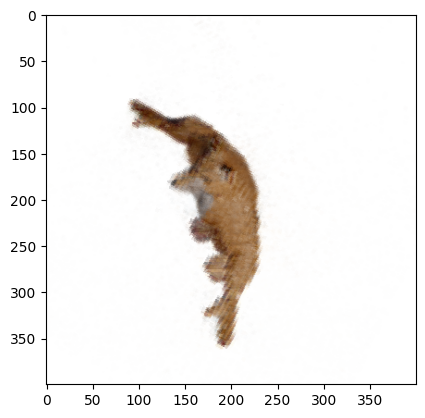

In [32]:
plt.imshow(img.reshape(400, 400, 3).data.cpu().numpy())

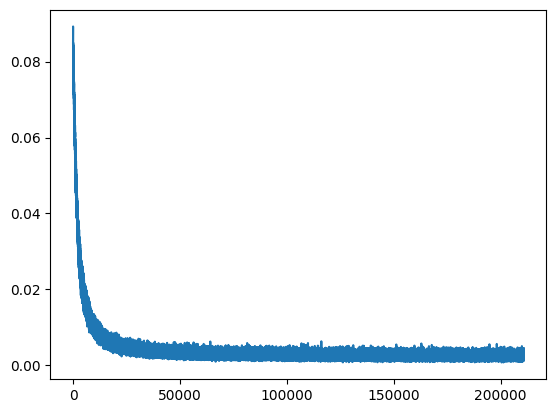

In [35]:
plt.plot(training_loss)

In [24]:
torch.save(model, "/content/drive/MyDrive/ColabNotebooks/NeRF/model_voxels")